In [1]:
import rqalpha as rqa
import rqalpha_plus
import rqdatac as rqd
import rqoptimizer as rqo
import datetime
import pickle
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.set_option('display.width',200)
rqd.init()

# 各行业各因子每日净值

In [2]:
def get_all_net_value_df(path = r'results-28-industry'):
    # 28个行业文件夹
    industry_list = [i for i in os.listdir(path) if os.path.splitext(i)[-1]=='.INDX']
    # 行业名称字典
    industry_name_dict = {i:rqd.instruments(i).symbol for i in industry_list}
    
    
    all_net_value_df = pd.DataFrame()
    # 每个行业里面的因子
    for ids in industry_list:
        industry_name = industry_name_dict[ids]
        path1 = path+'\\'+ids
        # 一个行业里面的因子
        factor_net_value = pd.DataFrame()
        for factor in [i for i in os.listdir(path1)]:
            path2 = path1+'\\'+factor
            with open(path2,'rb') as pf:
                result = pickle.load(pf)
            config,backtest = result[0],result[1]
            if backtest is None:
                continue
            portfolio = backtest['sys_analyser']['portfolio']
            # 净值
            net_value = portfolio['static_unit_net_value']
            factor_name = factor.split('.')[0]
            # 列名
            net_value.name = factor_name
            factor_net_value = pd.concat([factor_net_value,net_value],axis=1)
        factor_net_value['industry'] = industry_name
        all_net_value_df = pd.concat([all_net_value_df,factor_net_value])
        all_net_value_df.index.name = 'date'
        all_net_value_df = all_net_value_df.reset_index().set_index(['industry','date'])
        
        
        return all_net_value_df

In [3]:
# all_net_value_df.to_excel('全行业财务因子2014-2020净值.xlsx')

# 各行业过去收益最大的因子

In [4]:
def get_best_factor(net_value,past_window,reverse=False):
    last_year_profit = net_value.groupby('industry').pct_change(past_profit_window).dropna()
    if not reverse:
        best_factor = last_year_profit.reset_index().groupby(['date','industry']).idxmax(axis=1).droplevel(2)
    else:
        best_factor = last_year_profit.reset_index().groupby(['date','industry']).idxmin(axis=1).droplevel(2)
    return best_factor

# 回测

In [5]:
def get_industry_weight(date,benchmark):
    # 今天指数成分股
    components = rqd.index_components(benchmark,date)
    # 股票所属行业series
    industry = rqd.shenwan_instrument_industry(components, date).loc[:, 'index_name'].rename('industry')
    # 指数行业权重
    industry_weight = rqd.index_weights(benchmark,date).groupby(industry).sum()
    
    return industry_weight

In [6]:
def get_daily_profit(best_factor,net_value,interval=20,benchmark='000905.XSHG'):
    dates = best_factor.index.levels[0].tolist()
    industry = best_factor.index.levels[1].tolist()
    # 初始化
    daily_profit = pd.DataFrame(index=best_factor.index,columns=['profit','weight'])
    lastdate = None
    # 调仓日列表
    balance_dates = dates[::interval]
    for date in dates:
        if lastdate is None:
            best_factor_series = best_factor.loc[date]
            industry_weight = get_industry_weight(date,benchmark)
            lastdate = date
            continue

        # 调仓日轮换因子和行业权重
        if date in balance_dates:
            # 轮换所有行业过去表现最好的因子
            best_factor_series = best_factor.loc[lastdate]
            industry_weight = get_industry_weight(date,benchmark)

        for ids in industry:
            # 选股因子
            select_factor = best_factor_series[ids]
            last_net_value = net_value.loc[(ids,lastdate),select_factor]
            current_net_value = net_value.loc[(ids,date),select_factor]
            daily_profit.loc[(date,ids),'profit'] = current_net_value/last_net_value-1
            daily_profit.loc[(date,ids),'weight'] = industry_weight[ids]
        # 权重归一
        date_str = date.strftime('%Y-%m-%d')
        daily_profit.loc[date_str,'weight'] = daily_profit.loc[date_str,'weight']/daily_profit.loc[date_str,'weight'].sum()
        lastdate = date
        
    daily_profit.dropna(inplace=True)
    daily_profit_total = daily_profit.groupby(level=0).apply(lambda x:(x['profit']*x['weight']).sum())    
    
    # benchmark
    benchmark_profit = rqd.get_price(benchmark,dates[0],dates[-1],fields=['close'])
    benchmark_profit = benchmark_profit.pct_change().dropna()    
    # strategy,benchmark,excess
    profits_df = daily_profit_total.to_frame()
    profits_df.columns = ['strategy']
    profits_df['bench'] = benchmark_profit
    profits_df = profits_df.apply(lambda x:(x+1).cumprod())
    profits_df['excess'] = profits_df['strategy']-profits_df['bench']    
    
    return profits_df

In [7]:
def visualization(df,past_window,interval):
    plt.figure(figsize=(16,6))
    plt.plot(df)
    plt.legend(['strategy','benchmark','excess'])
    plt.title(f'{past_window}past profit,{interval} rebalance')
    plt.show()

# 参数

In [13]:
past_profit_window = 60
interval = 5

In [14]:
def back_test(past_window,interval):
    all_net_value_df = get_all_net_value_df()
    best_factor = get_best_factor(all_net_value_df,past_window)
    profits_df = get_daily_profit(best_factor,all_net_value_df,interval,'000905.XSHG')
    visualization(profits_df,past_window,interval)

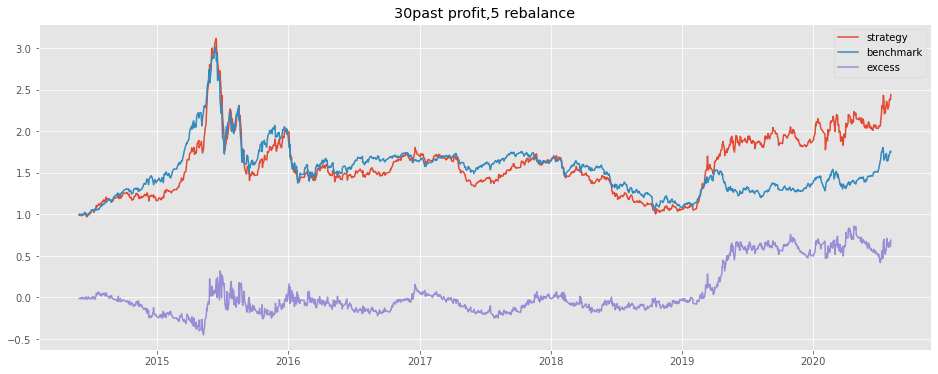

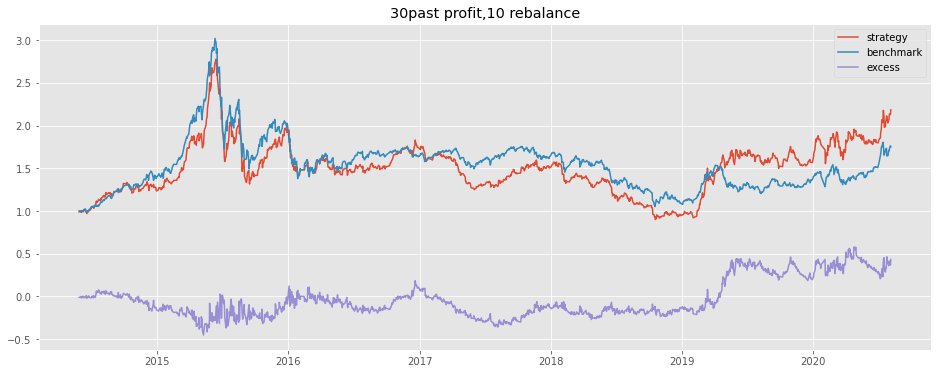

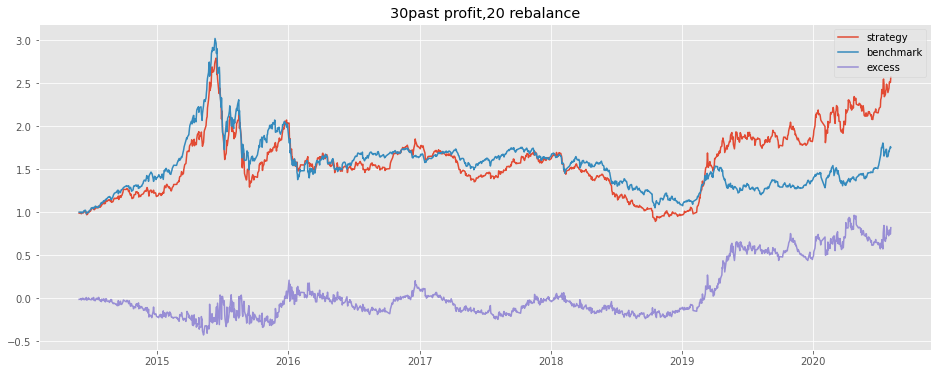

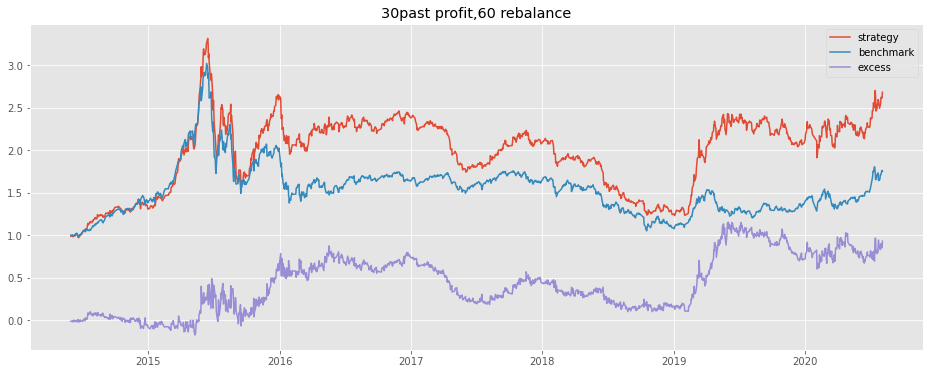

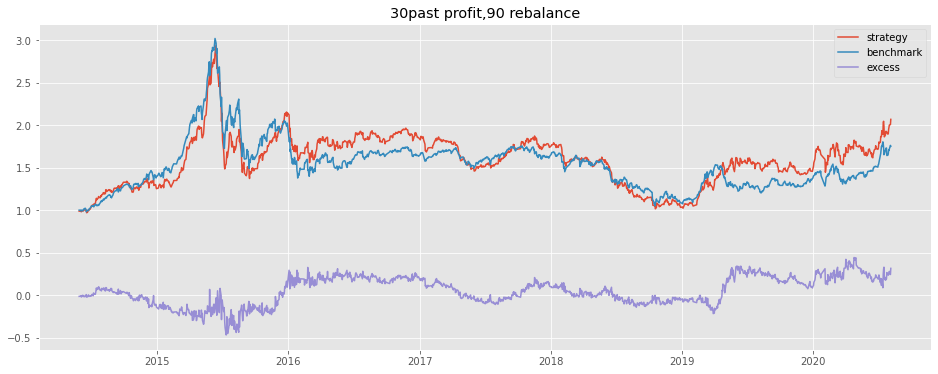

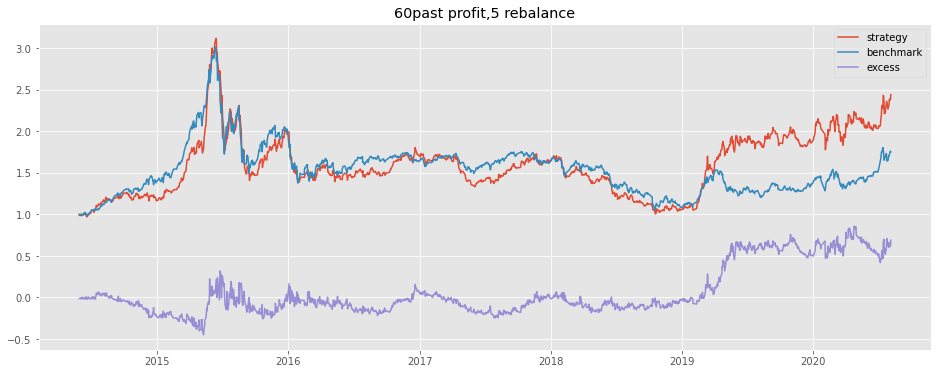

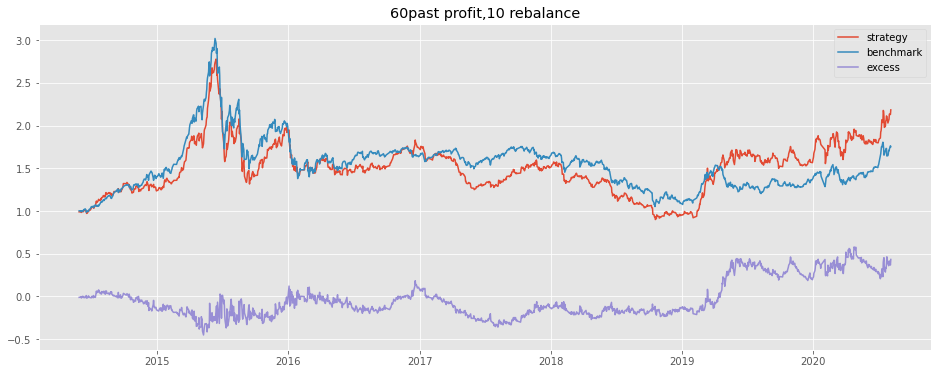

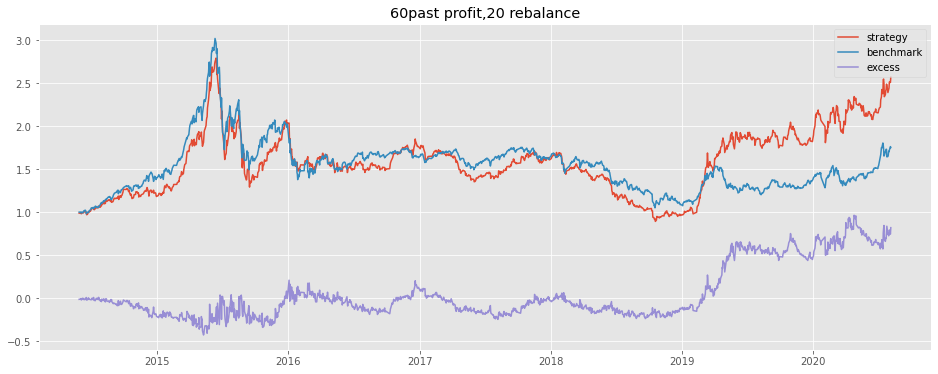

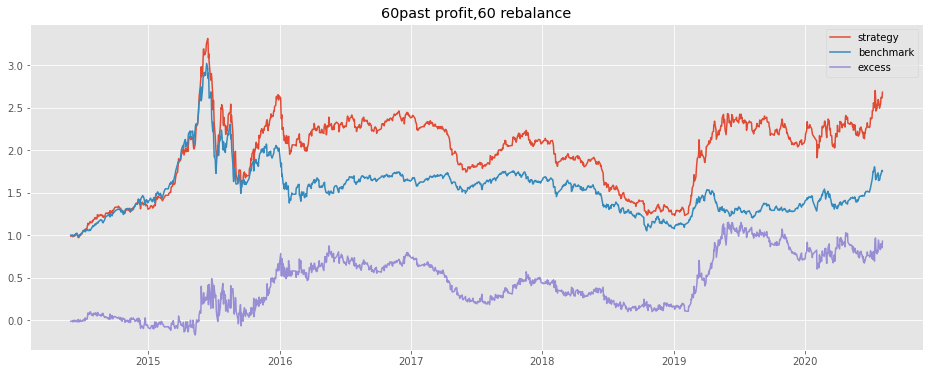

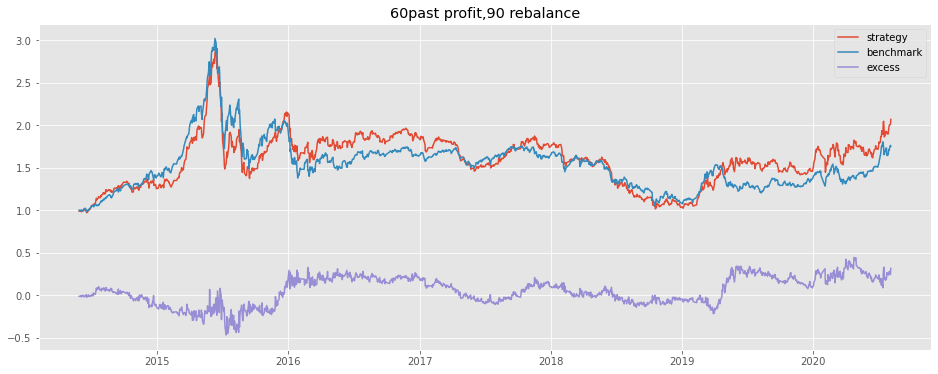

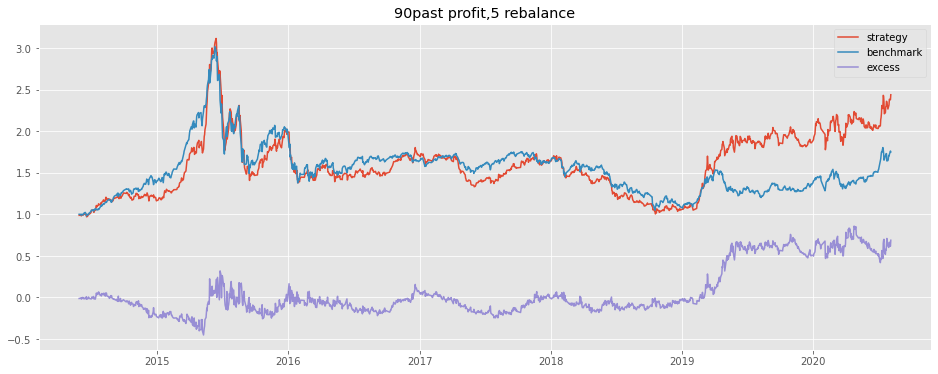

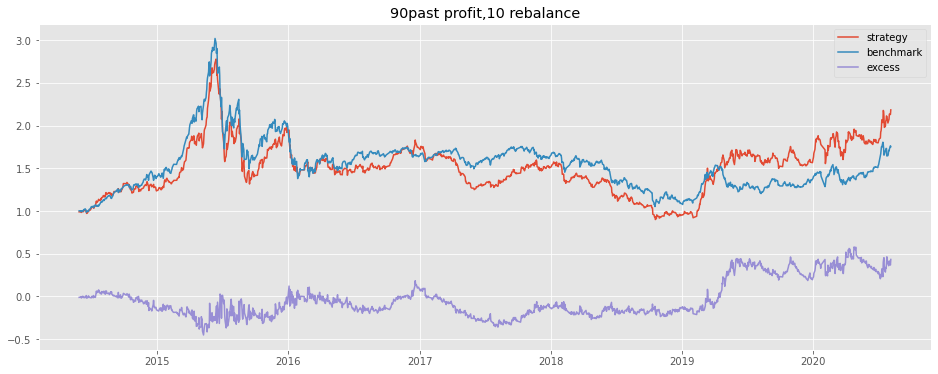

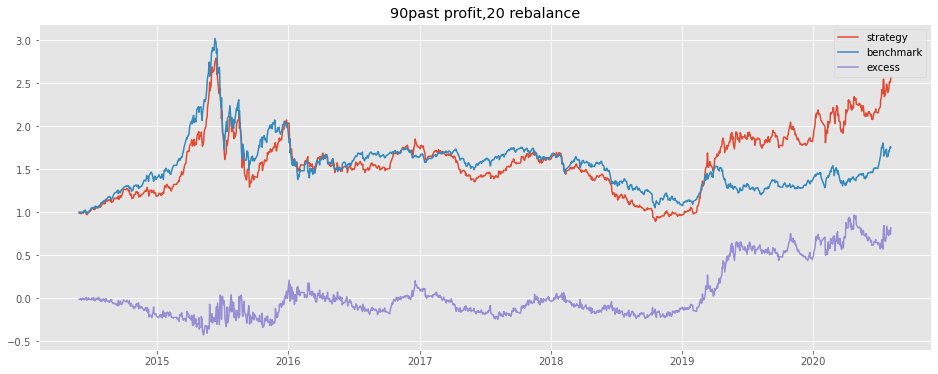

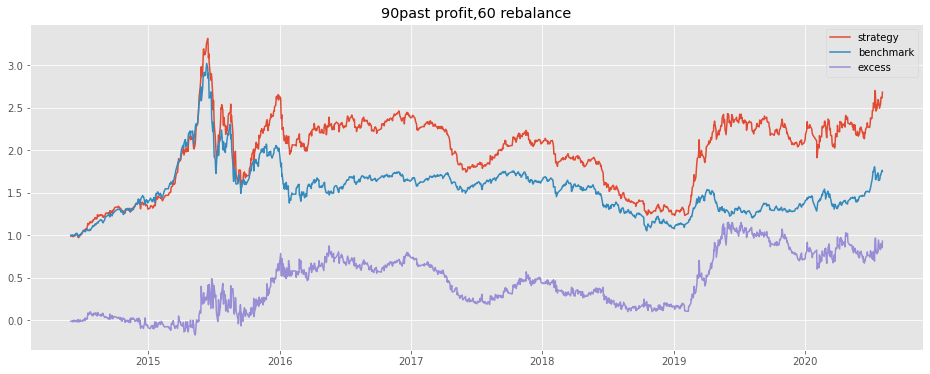

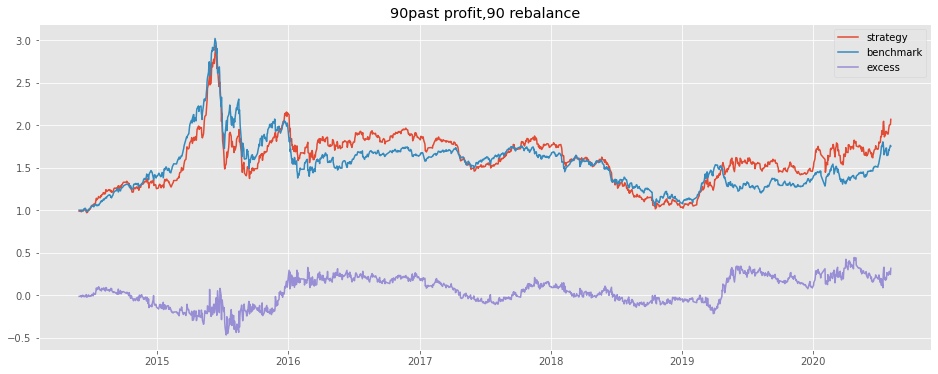

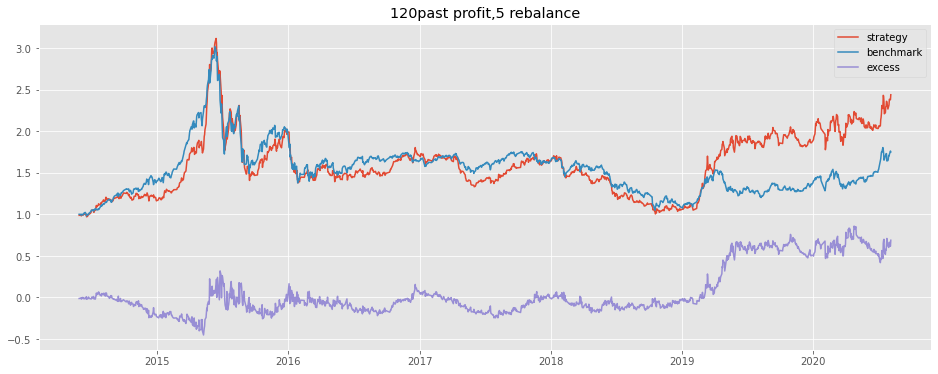

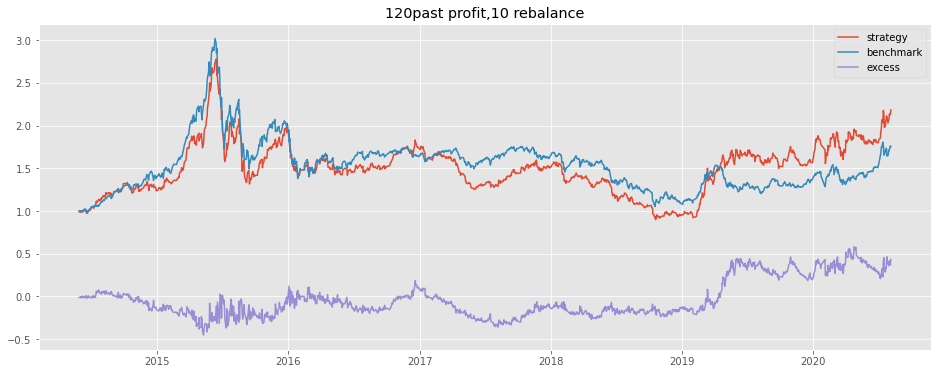

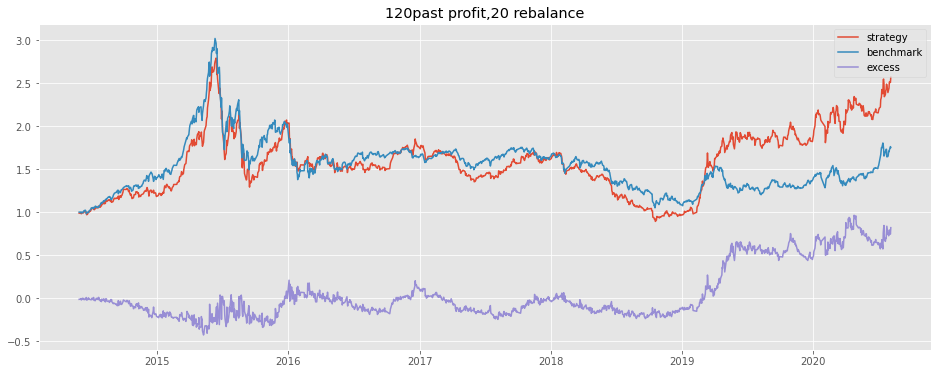

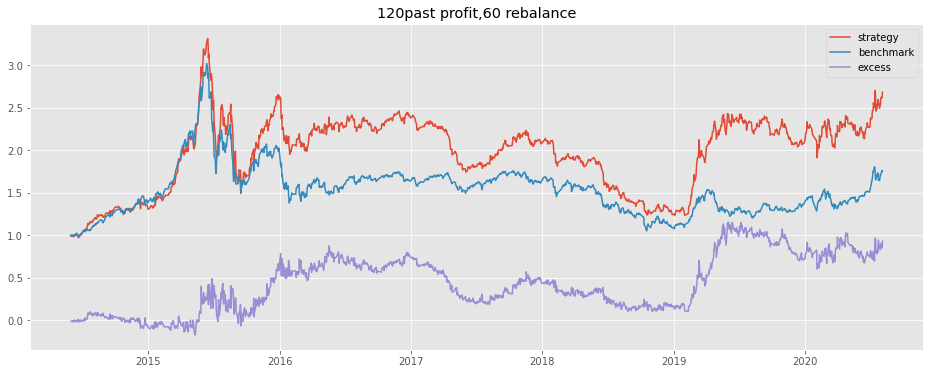

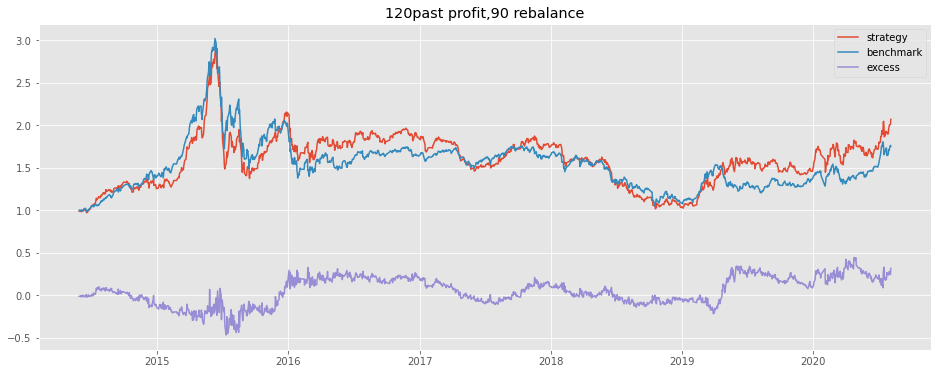

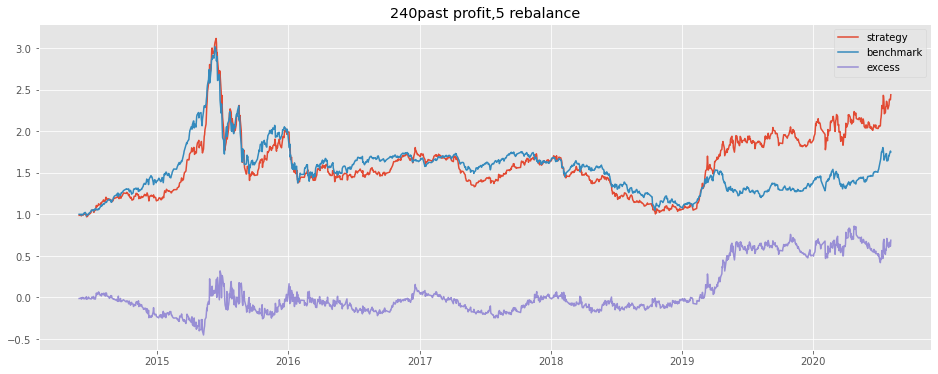

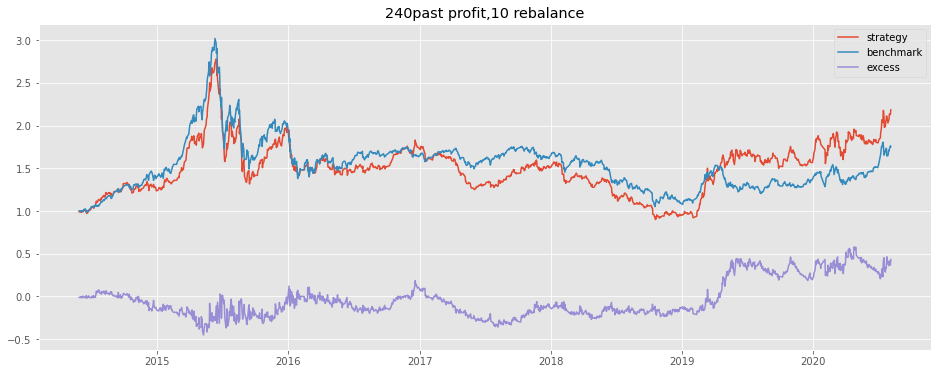

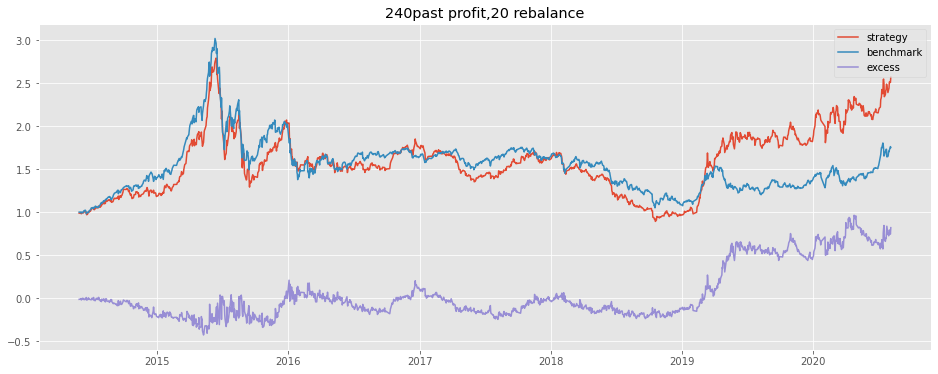

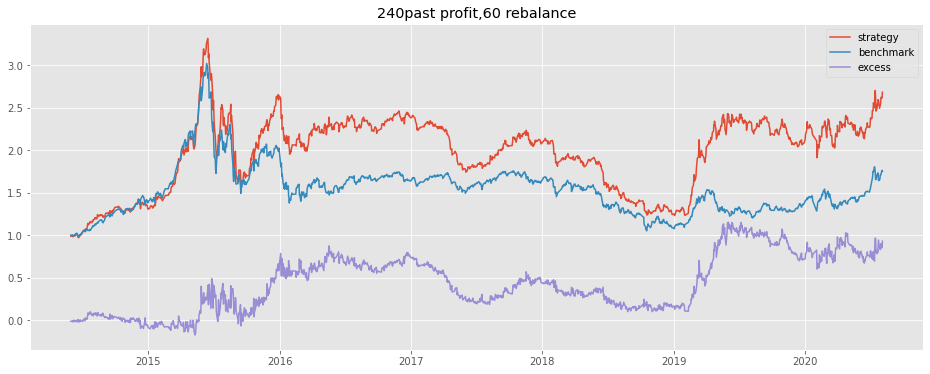

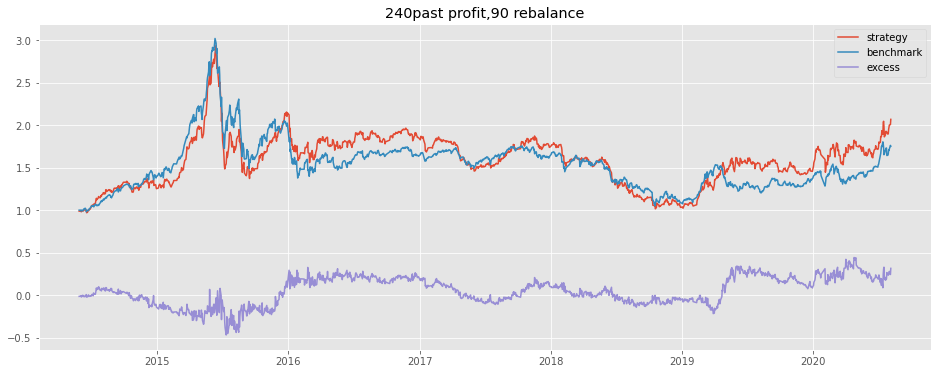

In [16]:
for i in [30,60,90,120,240]:
    for j in [5,10,20,60,90]:
        back_test(i,j)